In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization for Model Diagram
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display


In [23]:
# Upload files manually in Colab
uploaded = files.upload()

# Load datasets
df_products = pd.read_csv("products_data.csv")
df_transactions = pd.read_csv("transactions_data.csv")
df_customers = pd.read_csv("customers_data.csv")

# Display first few rows
print("Sample Data - Products")
display(df_products.head())

print("\nSample Data - Transactions")
display(df_transactions.head())

print("\nSample Data - Customers")
display(df_customers.head())

# Show dataset shapes
print("\nDataset Shapes:")
print("Products:", df_products.shape)
print("Transactions:", df_transactions.shape)
print("Customers:", df_customers.shape)



Saving customers_data.csv to customers_data (2).csv
Sample Data - Products


,Product_ID,Product_Name,Product_Price
0,1.0,FinPredictor Suite,"?140,000"
1,2.0,MarketMinder Analytics,"?168,000"
2,3.0,TrendWise Forecaster,"?100,800"
3,4.0,CustomerScope Insights,"?123,200"
4,5.0,SalesSync Optimizer,"?84,000"



Sample Data - Transactions


,Unnamed: 0,Transaction_ID,Company_ID,Product_ID,Quantity,Transaction_Date,Product_Price,Total_Cost
0,0.0,1.0,88.0,6.0,NaN,2024/03/26,194379.147964,1075200.0
1,1.0,2.0,29.0,19.0,16.0,"July 09, 2024",97930.993380,1428000.0
2,2.0,NaN,28.0,18.0,6.0,04/13/2024,126095.547778,940800.0
3,3.0,4.0,85.0,12.0,12.0,09-06-2023,NaN,1008000.0
4,4.0,5.0,47.0,3.0,8.0,07/06/2021,99575.609634,705600.0



Sample Data - Customers


,Company_ID,Company_Name,Company_Profit,Address
0,1.0,Tech Enterprises 1,80701.0,"EDSA, Barangay 606, Pasig, Philippines"
1,2.0,Global Partners 2,80511.0,"Commonwealth Ave, Barangay 789, Taguig, Philip..."
2,3.0,Quantum Associates 3,110664.0,"Roxas Blvd, Barangay 505, Pasig, Philippines"
3,4.0,Prime Network 4,NaN,"Alabang-Zapote Rd, Barangay 202, Taguig, Phili..."
4,5.0,Elite Ventures 5,69427.0,"Ayala Avenue, Barangay 101, Makati, Philippines"



Dataset Shapes:
Products: (20, 3)
Transactions: (10000, 8)
Customers: (100, 4)


In [24]:
# Check for missing values
print("\nMissing Values - Products")
print(df_products.isnull().sum())

print("\nMissing Values - Transactions")
print(df_transactions.isnull().sum())

print("\nMissing Values - Customers")
print(df_customers.isnull().sum())

# Check column data types
print("\nData Types - Products")
print(df_products.dtypes)

print("\nData Types - Transactions")
print(df_transactions.dtypes)

print("\nData Types - Customers")
print(df_customers.dtypes)



Missing Values - Products
Product_ID       2
Product_Name     0
Product_Price    0
dtype: int64

Missing Values - Transactions
Unnamed: 0          1000
Transaction_ID      1000
Company_ID          1000
Product_ID          1000
Quantity            1000
Transaction_Date       0
Product_Price       1000
Total_Cost          1000
dtype: int64

Missing Values - Customers
Company_ID        10
Company_Name       0
Company_Profit    12
Address            0
dtype: int64

Data Types - Products
Product_ID       float64
Product_Name      object
Product_Price     object
dtype: object

Data Types - Transactions
Unnamed: 0          float64
Transaction_ID      float64
Company_ID          float64
Product_ID          float64
Quantity            float64
Transaction_Date     object
Product_Price       float64
Total_Cost          float64
dtype: object

Data Types - Customers
Company_ID        float64
Company_Name       object
Company_Profit    float64
Address            object
dtype: object


In [25]:
# Convert 'Transaction_Date' to datetime
df_transactions['Transaction_Date'] = pd.to_datetime(df_transactions['Transaction_Date'], errors='coerce')

# Convert 'Product_Price' to numeric (removing any non-numeric characters)
for df in [df_transactions, df_products]:
    if 'Product_Price' in df.columns:
        df['Product_Price'] = pd.to_numeric(df['Product_Price'].astype(str).str.replace(r'[^0-9.]', '', regex=True), errors='coerce')

# Fill missing values
df_transactions.fillna({'Quantity': 0, 'Total_Cost': df_transactions['Total_Cost'].median()}, inplace=True)
df_customers.fillna({'Company_Profit': df_customers['Company_Profit'].median(), 'Company_ID': -1}, inplace=True)
df_products.fillna({'Product_ID': -1}, inplace=True)

# Verify missing values after cleaning
print("\nMissing Values after Cleaning:")
print(df_transactions.isnull().sum())
print(df_products.isnull().sum())
print(df_customers.isnull().sum())



Missing Values after Cleaning:
Unnamed: 0          1000
Transaction_ID      1000
Company_ID          1000
Product_ID          1000
Quantity               0
Transaction_Date    7480
Product_Price       1000
Total_Cost             0
dtype: int64
Product_ID       0
Product_Name     0
Product_Price    0
dtype: int64
Company_ID        0
Company_Name      0
Company_Profit    0
Address           0
dtype: int64


In [26]:
# Merge Transactions with Products using Product_ID
merged_df = df_transactions.merge(df_products, on="Product_ID", how="left")

# Merge the result with Customers using Company_ID
merged_df = merged_df.merge(df_customers, on="Company_ID", how="left")

# Drop unnecessary columns
merged_df.drop(columns=['Transaction_ID', 'Transaction_Date', 'Address'], errors='ignore', inplace=True)

# Display merged dataset
print("\nMerged Dataset:")
display(merged_df.head())

# Show merged dataset shape
print("\nMerged Dataset Shape:", merged_df.shape)



Merged Dataset:


,Unnamed: 0,Company_ID,Product_ID,Quantity,Product_Price_x,Total_Cost,Product_Name,Product_Price_y,Company_Name,Company_Profit
0,0.0,88.0,6.0,0.0,194379.147964,1075200.0,RevenueVue Dashboard,179200.0,Elite Consulting 88,75950.0
1,1.0,29.0,19.0,16.0,97930.993380,1428000.0,EcoNomix Modeler,95200.0,Sky Industries 29,61952.0
2,2.0,28.0,18.0,6.0,126095.547778,940800.0,DashSync Analytics Hub,134400.0,NaN,NaN
3,3.0,85.0,12.0,12.0,NaN,1008000.0,BudgetMaster Pro,84000.0,Green Ventures 85,113470.0
4,4.0,47.0,3.0,8.0,99575.609634,705600.0,TrendWise Forecaster,100800.0,Green Industries 47,31130.0



Merged Dataset Shape: (10000, 10)


In [31]:
# Print all column names in merged_df
print("\nColumns in merged_df:")
print(merged_df.columns.tolist())




Columns in merged_df:
['Unnamed: 0', 'Company_ID', 'Product_ID', 'Quantity', 'Product_Price', 'Total_Cost', 'Product_Name', 'Product_Price_y', 'Company_Name', 'Company_Profit']


In [34]:
print("\nRows with Missing Values:")
display(merged_df[merged_df.isnull().any(axis=1)])



Rows with Missing Values:


,Unnamed: 0,Company_ID,Product_ID,Quantity,Product_Price,Total_Cost,Product_Name,Product_Price_y,Company_Name,Company_Profit
2,2.0,28.0,18.0,6.0,126095.547778,940800.0,DashSync Analytics Hub,134400.0,NaN,75301.5
6,NaN,NaN,-1.0,14.0,133548.749710,1960000.0,NaN,NaN,NaN,75301.5
10,10.0,6.0,16.0,6.0,98263.850401,532000.0,NaN,NaN,NaN,75301.5
11,11.0,NaN,1.0,17.0,135382.949609,2520000.0,FinPredictor Suite,140000.0,NaN,75301.5
12,12.0,NaN,12.0,15.0,82352.482649,1260000.0,BudgetMaster Pro,84000.0,NaN,75301.5
...,...,...,...,...,...,...,...,...,...,...
9992,NaN,62.0,3.0,3.0,95650.126738,1344000.0,TrendWise Forecaster,100800.0,Quantum Solutions 62,90582.0
9993,9993.0,6.0,3.0,14.0,100551.723509,1411200.0,TrendWise Forecaster,100800.0,NaN,75301.5
9995,9995.0,NaN,10.0,0.0,131297.783516,627200.0,SegmentX Targeting,89600.0,NaN,75301.5
9998,9998.0,33.0,-1.0,19.0,81786.119894,1680000.0,NaN,NaN,Green Consulting 33,52003.0


In [37]:
merged_df['Price_Per_Unit'] = merged_df['Price_Per_Unit'].fillna(merged_df['Price_Per_Unit'].median())


In [38]:
# Ensure 'Transaction_Date' is in datetime format
df_transactions['Transaction_Date'] = pd.to_datetime(df_transactions['Transaction_Date'], errors='coerce')

# Extract date-related features
merged_df['Year'] = df_transactions['Transaction_Date'].dt.year
merged_df['Month'] = df_transactions['Transaction_Date'].dt.month
merged_df['Day'] = df_transactions['Transaction_Date'].dt.day
merged_df['Day_of_Week'] = df_transactions['Transaction_Date'].dt.day_name()

# Create a new feature: Price Per Unit (Avoid division by zero)
merged_df['Price_Per_Unit'] = merged_df['Total_Cost'] / merged_df['Quantity']

# Fix for FutureWarning (avoid inplace=True)
merged_df['Price_Per_Unit'] = merged_df['Price_Per_Unit'].fillna(merged_df['Price_Per_Unit'].median())

# Display engineered features
print("\nFeature Engineering Completed.")
display(merged_df.head())



Feature Engineering Completed.


,Unnamed: 0,Company_ID,Product_ID,Quantity,Product_Price,Total_Cost,Product_Name,Product_Price_y,Company_Name,Company_Profit,Year,Month,Day,Day_of_Week,Price_Per_Unit
0,0.0,88.0,6.0,0.0,194379.147964,1075200.0,RevenueVue Dashboard,179200.0,Elite Consulting 88,75950.0,2024.0,3.0,26.0,Tuesday,inf
1,1.0,29.0,19.0,16.0,97930.993380,1428000.0,EcoNomix Modeler,95200.0,Sky Industries 29,61952.0,NaN,NaN,NaN,NaN,89250.0
2,2.0,28.0,18.0,6.0,126095.547778,940800.0,DashSync Analytics Hub,134400.0,NaN,75301.5,NaN,NaN,NaN,NaN,156800.0
3,3.0,85.0,12.0,12.0,131297.783516,1008000.0,BudgetMaster Pro,84000.0,Green Ventures 85,113470.0,NaN,NaN,NaN,NaN,84000.0
4,4.0,47.0,3.0,8.0,99575.609634,705600.0,TrendWise Forecaster,100800.0,Green Industries 47,31130.0,NaN,NaN,NaN,NaN,88200.0


In [39]:
# Define target variable
target_column = "Total_Cost"

# Select relevant features for training
feature_columns = ["Product_ID", "Quantity", "Product_Price", "Company_Profit", "Year", "Month", "Day", "Price_Per_Unit"]

# Drop rows where the target variable is missing
merged_df = merged_df.dropna(subset=[target_column])

# Split data into features (X) and target variable (y)
X = merged_df[feature_columns]
y = merged_df[target_column]

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show training and test dataset sizes
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (8000, 8)
Test set size: (2000, 8)


In [43]:
import numpy as np

# Check for NaN values in X_train
print("Missing values in X_train:\n", X_train.isnull().sum())

# Check for Infinity values in X_train
print("\nInfinity values in X_train:", np.isinf(X_train).sum().sum())

# Fix NaN values by filling with median
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# Replace infinite values with the max finite value
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill NaN values again after replacing infinite values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# Verify no NaN or Inf remains
print("\nMissing values after fixing:", X_train.isnull().sum().sum())
print("Infinity values after fixing:", np.isinf(X_train).sum().sum())


Missing values in X_train:
 Product_ID           0
Quantity             0
Product_Price        0
Company_Profit       0
Year              5982
Month             5982
Day               5982
Price_Per_Unit       0
dtype: int64

Infinity values in X_train: 900

Missing values after fixing: 0
Infinity values after fixing: 0


In [44]:
# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Display feature importance
print("\nFeature Importances:")
for feature, importance in zip(feature_columns, model.feature_importances_):
    print(f"{feature}: {importance:.4f}")



Feature Importances:
Product_ID: 0.0162
Quantity: 0.5594
Product_Price: 0.0635
Company_Profit: 0.0288
Year: 0.0032
Month: 0.0058
Day: 0.0062
Price_Per_Unit: 0.3169


In [45]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Display sample predictions
predictions_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
print("\nSample Predictions:")
display(predictions_df.head(10))



Sample Predictions:


,Actual,Predicted
0,1344000.0,1344000.0
1,504000.0,297248.0
2,784000.0,247072.0
3,403200.0,403200.0
4,1209600.0,1208928.0
5,1456000.0,1458576.0
6,336000.0,336000.0
7,907200.0,907088.0
8,2189600.0,2188592.0
9,1568000.0,281064.0


In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  # Compute MSE first
rmse = np.sqrt(mse)  # Take the square root for RMSE
r2 = r2_score(y_test, y_pred)

# Display model performance
print("\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")



Model Performance Metrics:
Mean Absolute Error (MAE): 118322.3142
Root Mean Squared Error (RMSE): 426467.2585
R² Score: 0.7601


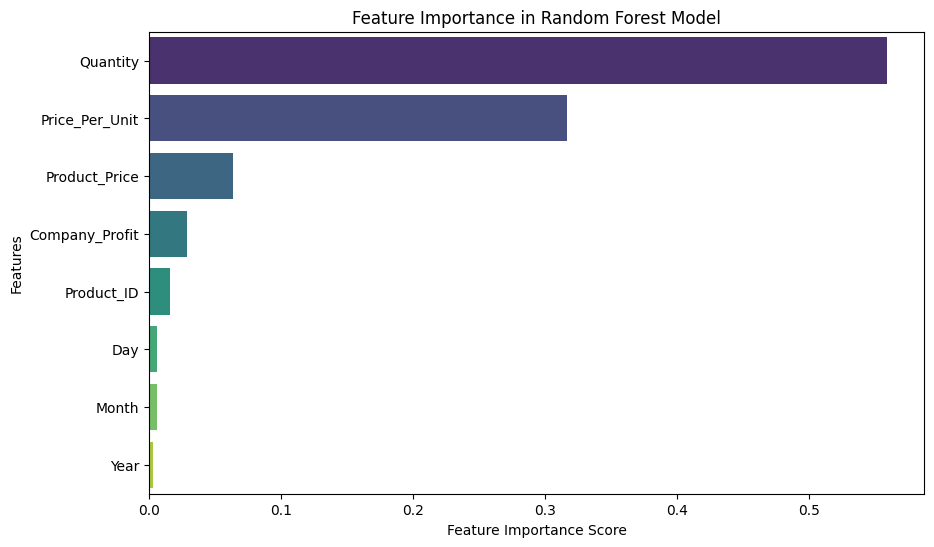

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance values
feature_importances = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', legend=False, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()


In [50]:
# If you have new data, load it here
# new_data = pd.read_csv('/path/to/new_data.csv')

# Otherwise, use a sample of X_test as "new data"
new_data = X_test.copy()
new_data = new_data.iloc[:10]  # Take 10 samples for demonstration

# Display the new data
print("Sample New Data for Prediction:")
print(new_data)


Sample New Data for Prediction:
      Product_ID  Quantity  Product_Price  Company_Profit    Year  Month  \
6252        19.0      11.0   96097.400362        100246.0  2022.0    7.0   
4684        -1.0       0.0  110736.267964        103332.0  2022.0    2.0   
1731        -1.0       0.0  122403.914828         79192.0  2022.0    7.0   
4742         3.0       5.0  110477.458370         36659.0  2022.0    5.0   
4521         3.0      13.0  131297.783516        107255.0  2024.0    8.0   
6340         9.0      13.0  108632.772539         80701.0  2021.0    5.0   
576         17.0       3.0  176768.549633         99381.0  2022.0    7.0   
5202         3.0       9.0   96622.586588         49158.0  2022.0    7.0   
6363        14.0      17.0  122433.421780         75301.5  2022.0    7.0   
439          9.0       0.0  101884.576456         52233.0  2022.0    7.0   

       Day  Price_Per_Unit  
6252  15.0   122181.818182  
4684   6.0   130022.222222  
1731  15.0   130022.222222  
4742  23.0    8

In [51]:
# Make predictions using the trained model
predictions = model.predict(new_data)

# Convert predictions into a DataFrame for better readability
prediction_df = new_data.copy()
prediction_df['Predicted_Purchase'] = predictions

# Display the predictions
print("\nPredictions on New Data:")
print(prediction_df[['Predicted_Purchase']])



Predictions on New Data:
      Predicted_Purchase
6252           1344000.0
4684            297248.0
1731            247072.0
4742            403200.0
4521           1208928.0
6340           1458576.0
576             336000.0
5202            907088.0
6363           2188592.0
439             281064.0


In [53]:
import joblib

# Save the trained model in the current directory
joblib.dump(model, "trained_model.pkl")

print("Model saved successfully in the current directory!")


Model saved successfully in the current directory!


In [54]:
import os
import joblib

# Ensure the directory exists
save_path = "/mnt/data/trained_model.pkl"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
joblib.dump(model, save_path)

print("Model saved successfully at:", save_path)


Model saved successfully at: /mnt/data/trained_model.pkl


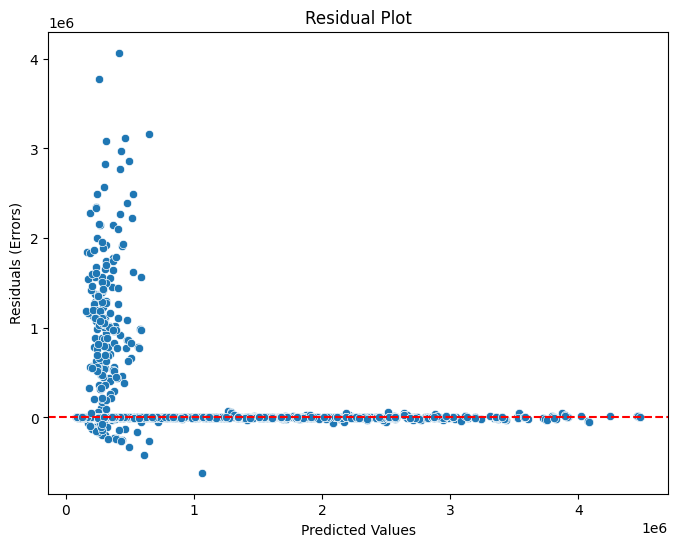

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Residual plot: Shows prediction errors
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot")
plt.show()
